In [15]:
%matplotlib inline

In [16]:
# import 
import matplotlib.pylab as plt
import numpy as np
    


In [25]:
def openfile(fname):
    f =  open(fname, 'r')

    line = f.next()
    a = (line.strip().split(" "))
    a = [b for b in a if b]

    Nx = int(a[0])
    Ny = int(a[1])
    Nz = int(a[2])
    Sx = float(a[3])
    Sy = float(a[4])
    Sz = float(a[5])

    Ox = float(a[6])
    Oy = float(a[7])
    Oz = float(a[8])

    line = f.next()
    a = (line.strip().split(" "))
    a = [b for b in a if b]
    nvar = int(a[0])

    line = f.next()
    a = (line.strip().split(" "))
    a = [b for b in a if b]
    name_of_variable_1 = (a[0])
    print name_of_variable_1,
    
    facies = np.zeros([Nx, Ny])
    for i in range(Ny):
        for j in range(Nx):
            facies[i, j] = int(f.next().split()[0])
            
    return facies, Nx, Ny

In [26]:
veg, Nx, Ny = openfile("ti.gslib")

veg


In [27]:
import numpy
from scipy import ndimage


def get_patches(fld):
    # Returns list of patch sizes
    s =  np.ones((3,3)) # iterate structure
    s[0, 0] = 0  # comment out for queen neighbors
    s[2, 0] = 0
    s[2, 2] = 0
    s[0, 2] = 0

    labeled_array, numpatches = ndimage.label(fld,s) # labeling
    sizes = ndimage.sum(fld,labeled_array,range(1,numpatches+1)) 
    return sizes

train_patches = get_patches(veg)
# sim_patches = get_patches(veg_real00000) 

In [43]:
def get_sims():
    import os
    os.chdir('output/')
    prefixed = [filename for filename in os.listdir('.') if filename.startswith("test")]
    sim_veg = []
    for name in prefixed[:100]:
        sim_veg.append(openfile(name)[0])
    os.chdir('../')
    return sim_veg
sim_veg = get_sims()

veg_real00000 veg_real00001 veg_real00002 veg_real00003 veg_real00004 veg_real00005 veg_real00006 veg_real00007 veg_real00008 veg_real00009 veg_real00010 veg_real00011 veg_real00012 veg_real00013 veg_real00014 veg_real00015 veg_real00016 veg_real00017 veg_real00018 veg_real00019 veg_real00020 veg_real00021 veg_real00022 veg_real00023 veg_real00024 veg_real00025 veg_real00026 veg_real00027 veg_real00028 veg_real00029 veg_real00030 veg_real00031 veg_real00032 veg_real00033 veg_real00034 veg_real00035 veg_real00036 veg_real00037 veg_real00038 veg_real00039 veg_real00040 veg_real00041 veg_real00042 veg_real00043 veg_real00044 veg_real00045 veg_real00046 veg_real00047 veg_real00048 veg_real00049 veg_real00050 veg_real00051 veg_real00052 veg_real00053 veg_real00054 veg_real00055 veg_real00056 veg_real00057 veg_real00058 veg_real00059 veg_real00060 veg_real00061 veg_real00062 veg_real00063 veg_real00064 veg_real00065 veg_real00066 veg_real00067 veg_real00068 veg_real00069 veg_real00070 veg_re

## Patch size distribution

In [173]:
nbins  = 15  # number of bins
numsim = len(sim_veg)  # number of DeeSee simulations
bins= np.floor(np.logspace(np.log10(2), np.log10(1000), nbins))
norm = bins[1:] - bins[:-1]
train_counts = plt.histogram(train_patches, bins=bins)[0]


In [174]:
sim_patches = []  # simulated list of patch size arrays 
sim_counts = []   # simulated list of patch counts 
for i in range(numsim):
    sim_patches.append(get_patches(sim_veg[i]))
    counts = plt.histogram(sim_patches[i], bins= bins)[0]
    sim_counts.append(counts)

sim_counts =  np.array(sim_counts) 
sim_counts_normed = sim_counts/np.expand_dims(norm, 0)  #  normed by bin size
cum_sim_counts = np.cumsum(sim_counts, 1)*np.expand_dims(norm, 0)  # cumulative patch size counts

In [175]:
# power law exponent for patch size distribution
def get_alpha(fld, xmin):
    n = fld[fld >= 2].shape[0]
    alpha = 1+ n/np.sum(np.log(fld[fld >= xmin]/xmin))
    sigma = (alpha - 1)/np.sqrt(n)
    return alpha, sigma

train_alpha, train_sigma  = get_alpha(train_patches, 2)


In [176]:
from statsmodels.stats.weightstats import DescrStatsW
sim_alphas = np.array([get_alpha(x, 2)[0] for x in sim_patches])  #    
weights = np.array([len(x) for x in sim_patches])    
alphaStats = DescrStatsW(sim_alphas, weights=weights, ddof=0)

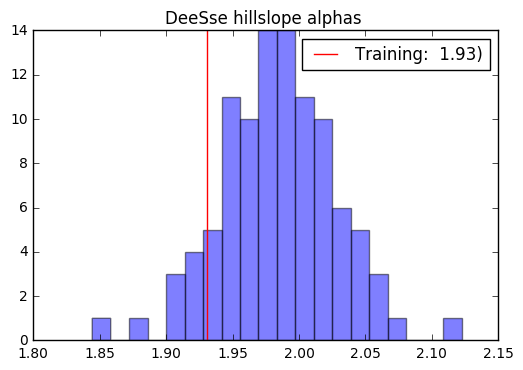

In [177]:
fig = plt.figure()
plt.hist(sim_alphas, 20, alpha = .5)
plt.title('DeeSse hillslope alphas ')
plt.axvline( x = train_alpha, color='r', linestyle='-',
            label = 'Training:  %.2f)' %train_alpha)
plt.legend(loc= 'best')
fig.savefig('plots/alphas_nx={0}.pdf'.format(Nx))

In [178]:
# vegetation fraction
weights = np.array([len(x) for x in sim_patches])
array = np.array([np.mean(x) for x in sim_patches])
sim_means = DescrStatsW(array, weights=weights, ddof=0) 

# mean patch size
array = np.array([np.sum(x) for x in sim_patches])/Nx/Ny  
sim_dens = DescrStatsW(array, weights=weights, ddof=0)

In [179]:
print 'Training:'
print '  mean veg density = {0:.3f}'.format(np.sum(train_patches)/Nx/Ny)
print '  mean patch size = {0:.1f}'.format(float(np.mean(train_patches)))
print '  alpha = {0:.2f}, sigma = {1:.2f}'.format(train_alpha, train_sigma)

print 'Simulation: '
print '  mean veg density = {0:.3f} +/- {1:.3f}'.format(sim_dens.mean,sim_dens.std )
print '  mean patch size = {0:.3f} +/- {1:.3f}'.format(sim_means.mean,sim_means.std )
print '  alpha = {0:.2f}, sigma = {1:.2f}'.format(alphaStats.mean, alphaStats.std)

Training:
  mean veg density = 0.204
  mean patch size = 8.6
  alpha = 1.93, sigma = 0.04
Simulation: 
  mean veg density = 0.174 +/- 0.012
  mean patch size = 8.090 +/- 0.738
  alpha = 1.98, sigma = 0.04


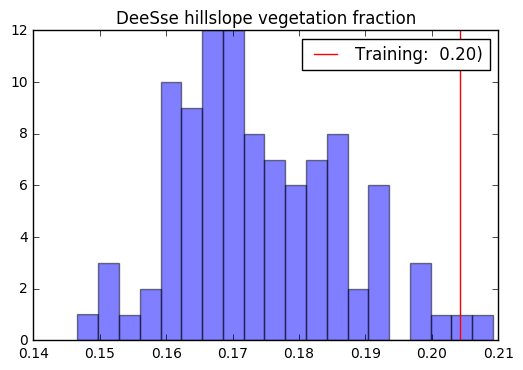

In [180]:
fig = plt.figure()
plt.hist(sim_dens.data, 20, alpha = .5)
plt.title('DeeSse hillslope vegetation fraction')
plt.axvline(x= (np.sum(train_patches)/Nx/Ny), color='r', linestyle='-',
            label = 'Training:  %.2f)' %(np.sum(train_patches)/Nx/Ny))
plt.legend(loc= 'best')
fig.savefig('plots/veg_fraction_nx={0}.pdf'.format(Nx))

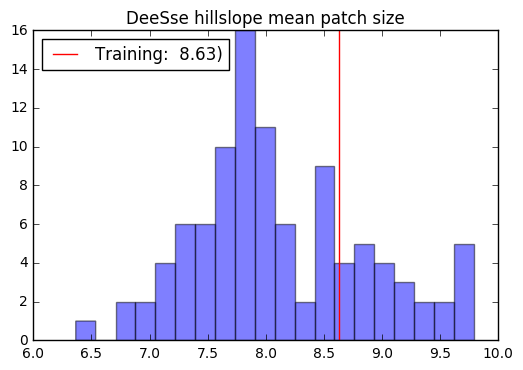

In [181]:
fig = plt.figure()
plt.hist(sim_means.data, 20, alpha = .5)
plt.title('DeeSse hillslope mean patch size')
plt.axvline(x= (np.mean(train_patches)), color='r', linestyle='-',
            label = 'Training:  %.2f)' %np.mean(train_patches))
plt.legend(loc= 'best')
fig.savefig('plots/patch_size_nx={0}.pdf'.format(Nx))

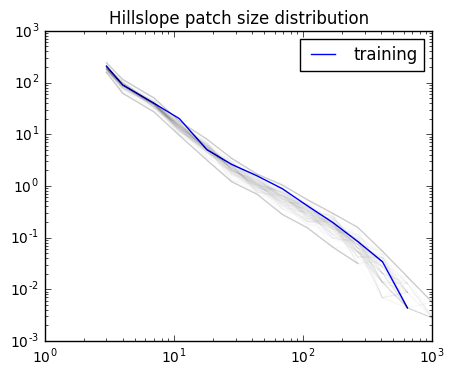

In [184]:
plt.figure(figsize = (11, 4))
plt.subplot(121)
plt.loglog(bins[1:], train_counts/norm, '-', label = 'training')
plt.loglog(bins[1:], sim_counts_normed.T, 'k-', alpha = .01)
plt.loglog(bins[1:], sim_counts_normed.max(0), 'k', alpha = .2)
plt.loglog(bins[1:], sim_counts_normed.min(0), 'k', alpha = .2)
plt.title('Hillslope patch size distribution')
plt.legend(loc='best')

# plt.subplot(122)
# plt.loglog(bins[1:], np.cumsum(train_counts)*norm, '-', label = 'training')
# plt.loglog(bins[1:], cum_sim_counts.T, 'k-', alpha = .01)
# plt.loglog(bins[1:], cum_sim_counts.max(0), 'k', alpha = .1)
# plt.loglog(bins[1:], cum_sim_counts.min(0), 'k', alpha = .1)
# plt.title('cumulative patch size distribution')
# plt.legend(loc='best')
# fig.savefig('plots/patch_size_dist_nx={0}.pdf'.format(Nx))

## Patch spacing

In [118]:
def get_spaces(fld):
    xspaces = []
    for i in range(0, Ny):
        count = 0
        for j in range(0, Nx):
            if fld[i, j] == 0:
                count += 1
            elif fld[i,j] ==1 and fld[i, j-1] ==0:
                xspaces.append(count)
                count = 0
                
    yspaces = []
    for j in range(0, Nx):
        count = 0
        for i in range(0, Ny):
            if fld[i, j] ==0:
                count += 1
            elif fld[i, j] == 1 and fld[i-1, j] ==0:
                yspaces.append(count)
                count = 0

    xspaces = np.array(xspaces)
    xspaces = xspaces[xspaces > 0]

    yspaces = np.array(yspaces)
    yspaces = yspaces[yspaces > 0]  
    return xspaces, yspaces

In [119]:
xspaces, yspaces = get_spaces(veg)  # training image spaces


In [144]:
deesse_xspace = []  # spacing along columns
deesse_yspace = []  # spacing along rows
for sim in sim_veg:
    simx, simy = get_spaces(sim)
    deesse_xspace.append(simx)
    deesse_yspace.append(simy)    

In [160]:
nbins  = 10  # number of bins
bins= np.logspace(np.log10(2), np.log10(200), nbins)
bins = np.floor(bins)
norm = bins[1:] - bins[:-1]


In [161]:
xspace_counts = []

for i in range(numsim):
    counts = plt.histogram(deesse_xspace[i], bins= bins)[0]
    xspace_counts.append(counts)

xspace_counts =  np.array(xspace_counts) 
xspace_counts_normed = xspace_counts/np.expand_dims(norm, 0)  #  normed by bin size
cum_xspace_counts = np.cumsum(xspace_counts, 1)*np.expand_dims(norm, 0)  # cumulative patch size counts

In [163]:
bins

array([   2.,    3.,    5.,    9.,   15.,   25.,   43.,   71.,  119.,  200.])

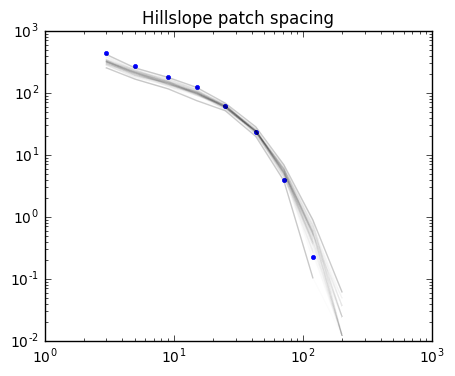

In [164]:
plt.figure(figsize = (11, 4))
plt.subplot(121)
x_counts, _ = plt.histogram(xspaces, bins=bins)
plt.loglog(bins[1:], x_counts/norm, '.', label = '')
plt.loglog(bins[1:], xspace_counts_normed.T, 'k-', alpha = .01)
plt.loglog(bins[1:], xspace_counts_normed.max(0), 'k', alpha = .2)
plt.loglog(bins[1:], xspace_counts_normed.min(0), 'k', alpha = .2)
plt.title('Hillslope patch spacing')
plt.legend(loc='best')

plt.subplot(122)
plt.loglog(bins[1:], np.cumsum(x_counts)*norm, '.', label = '')
plt.loglog(bins[1:], cum_xspace_counts.T, 'k-', alpha = .01)
plt.loglog(bins[1:], cum_xspace_counts.max(0), 'k', alpha = .1)
plt.loglog(bins[1:], cum_xspace_counts.min(0), 'k', alpha = .1)
plt.title('Hillslope cumulative patch spacing')
plt.legend(loc='best')
fig.savefig('plots/patch_spacing_nx={0}.pdf'.format(Nx))

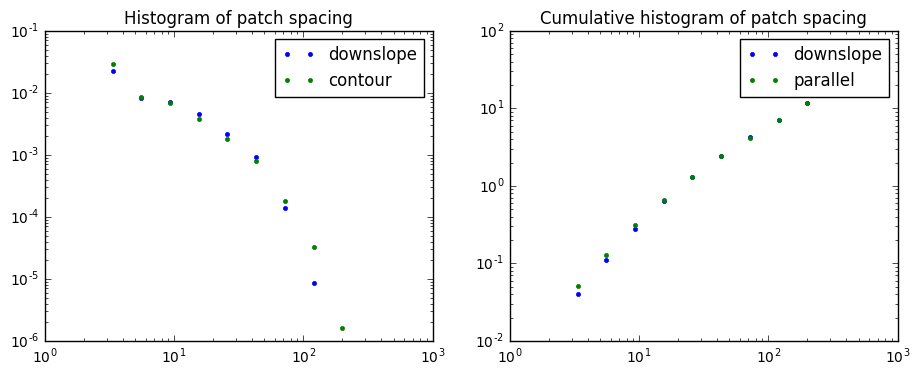

In [157]:
plt.figure(figsize = (11, 4))

plt.subplot(121)
x_counts, _ = plt.histogram(xspaces, bins=bins, normed= True)
plt.loglog(bins[1:], x_counts/norm, '.', label = 'downslope')
# plt.loglog(bins[1:], x_C*bins[1:]**-alpha)
y_counts, _ = plt.histogram(yspaces, bins=bins, normed= True)
plt.loglog(bins[1:], y_counts/norm, '.', label = 'contour')
plt.legend(loc = 'best')
plt.title('Histogram of patch spacing')

plt.subplot(122)
plt.loglog(bins[1:], np.cumsum(x_counts)*norm, '.', label = 'downslope')
plt.loglog(bins[1:], np.cumsum(y_counts)*norm, '.', label = 'parallel')
plt.legend(loc = 'best')
plt.title('Cumulative histogram of patch spacing')
# # plt.imshow(slope, cmap='gist_earth', extent=[x0, x1, y1, y0])

## Edges

In [190]:
def get_edges(fld):
    import scipy.signal

    s = np.ones((3, 3)) # iterate structure
    s[0, 0] = 0
    s[2, 0] = 0
    s[2, 2] = 0
    s[0, 2] = 0
    
    counts = scipy.signal.convolve2d(fld, s, mode='same')
    counts[fld == 0] = 0
    counts[counts == 5] = 0
    counts[counts>0] = 1
    return counts


def get_edge_fraction(fld):
    edges = get_edges(fld)
    
    s = np.ones((3, 3)) # iterate structure
    s[0, 0] = 0
    s[2, 0] = 0
    s[2, 2] = 0
    s[0, 2] = 0
    
    labeled_array, numpatches = ndimage.label(fld,s) # labeling
    sizes = ndimage.sum(fld,labeled_array,range(1,numpatches+1)) 
    
    labeled_array, numpatches = ndimage.label(edges,s) # labeling
    edge_sizes = ndimage.sum(fld,labeled_array,range(1,numpatches+1)) 
    return sum(edge_sizes)/sum(sizes)

In [191]:
edges = get_edges(veg)
edge_fraction = get_edge_fraction(veg)

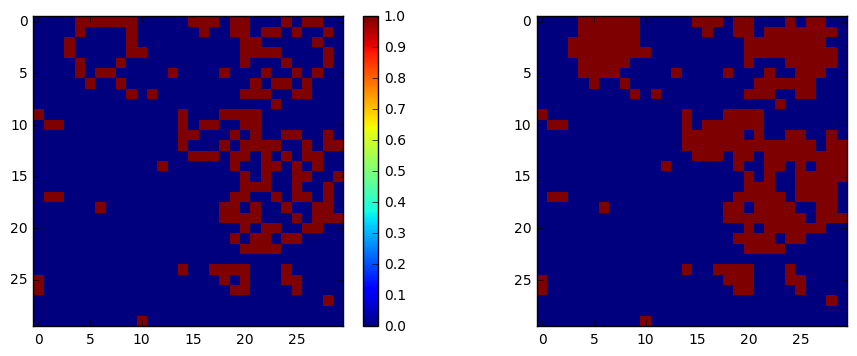

In [189]:
plt.figure(figsize=  (11, 4))
plt.subplot(121)
plt.imshow(edges[:30, :30], interpolation='none')
plt.colorbar()
plt.subplot(122)
plt.imshow(veg[:30, :30], interpolation='none')


In [194]:
sim_edge_fracs = []  # simulated list of edge fraction
for i in range(numsim):
    sim_edge_fracs.append(get_edge_fraction(sim_veg[i]))


In [197]:
edge_fraction

0.6710031347962383

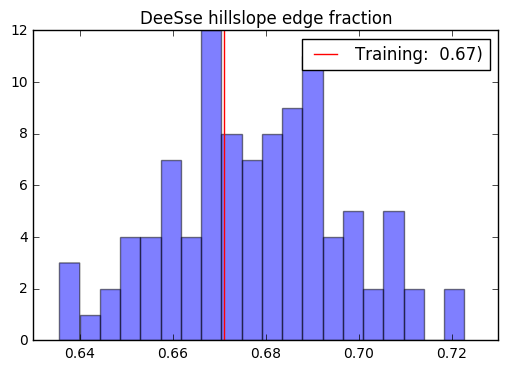

In [199]:
fig = plt.figure()
plt.hist(sim_edge_fracs, 20, alpha = .5)
plt.title('DeeSse hillslope edge fraction')
plt.axvline(x= edge_fraction, color='r', linestyle='-',
            label = 'Training:  %.2f)' %edge_fraction)
plt.legend(loc= 'best')
fig.savefig('plots/edge_fraction_nx={0}.pdf'.format(Nx))

In [ ]:
# show Deesse images
# for i in range(5):
#     fig = plt.figure(figsize = (9,4))
#     ax = fig.add_subplot(121)
#     plt.imshow(veg, cmap = 'Greens')
#     plt.title('Training image')
#     ax = fig.add_subplot(122)
#     plt.imshow(sim_veg[i], cmap = 'Greens')
#     plt.title('Simulated image')
#     plt.title('Simulation image')
#     fig.savefig('../plots/veg{}.pdf'.format(i))